# Seq2seq 프로젝트: 한영 번역기 만들기

In [1]:
# 한글폰트 설치: 실행후 런타임 재시작 필요
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 8 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 2s (5,578 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 120882 files and direc

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47800 (\N{HANGUL SYLLABLE MOM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47924 (\N{HANGUL SYLLABLE MU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44172 (\N{HANGUL SYLLABLE GE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50752 (\N{HANGUL SYLLABLE WA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


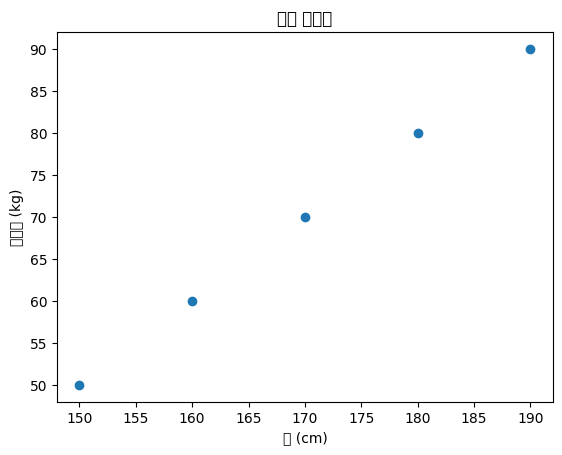

In [2]:
# 한글 표시 여부 확인
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'NanumBarunGothic' # 나눔바른고딕 적용하기

# 예제 데이터
heights = [150, 160, 170, 180, 190]  # 키 (cm)
weights = [50, 60, 70, 80, 90]       # 몸무게 (kg)

# 산점도 그리기
plt.scatter(heights, weights)

# 제목 및 레이블 추가
plt.title("키와 몸무게")
plt.xlabel("키 (cm)")
plt.ylabel("몸무게 (kg)")

# 그래프 표시
plt.show()

## 데이터 정제

In [3]:
# 학습 데이터 다운로드
!git clone https://github.com/jungyeul/korean-parallel-corpora.git

# 한-영 뉴스 코퍼스 압축해제
!mkdir kor-eng-train
!tar -xzf ./korean-parallel-corpora/korean-english-news-v1/korean-english-park.train.tar.gz -C kor-eng-train/

Cloning into 'korean-parallel-corpora'...
remote: Enumerating objects: 173, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 173 (delta 18), reused 0 (delta 0), pack-reused 131
Receiving objects: 100% (173/173), 20.48 MiB | 11.78 MiB/s, done.
Resolving deltas: 100% (61/61), done.


In [4]:
# 데이터 확인
def read_and_print_examples(file_path, num_examples=100, step=20):
    with open(file_path, "r", encoding='utf-8') as f:
        raw = f.read().splitlines()

    print(f"Data Size in {file_path}: {len(raw)}")
    print("Examples:")

    for sen in raw[:num_examples:step]:
        print(">>", sen)

# 영어 파일 읽기 및 출력
read_and_print_examples("./kor-eng-train/korean-english-park.train.en")

# 한국어 파일 읽기 및 출력
read_and_print_examples("./kor-eng-train/korean-english-park.train.ko")

Data Size in ./kor-eng-train/korean-english-park.train.en: 94123
Examples:
>> Much of personal computing is about "can you top this?"
>> Amid mounting pressure on North Korea to abandon its nuclear weapons program Japanese and North Korean diplomats have resumed talks on normalizing diplomatic relations.
>> “Guard robots are used privately and professionally to detect intruders or fire,” Karlsson said.
>> Authorities from the Water Resources Ministry plan to begin construction next year on the controversial and hugely expensive project.
>> Researchers also have debated whether weight-training has a big impact on the heart, since it does not give the heart and lungs the kind of workout they get from aerobic activities such as brisk walking or running for at least 20 minutes.
Data Size in ./kor-eng-train/korean-english-park.train.ko: 94123
Examples:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를

In [ ]:
# 설치 후 런타임 다시 시작 필요
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
!bash ./Mecab-ko-for-Google-Colab/install_mecab-ko_on_colab_light_220429.sh

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 138, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 138 (delta 26), reused 22 (delta 8), pack-reused 91
Receiving objects: 100% (138/138), 1.72 MiB | 10.91 MiB/s, done.
Resolving deltas: 100% (65/65), done.
Installing konlpy.....
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 15.5 MB/s eta 0:00:00
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2023-11-16 11:59:04--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::22cd:e0db
Connecting to bitbucket.org (bitbucket.org)|104.192.141.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://bbu

In [ ]:
import re

# 공통 전처리 함수

kor_path = "./kor-eng-train/korean-english-park.train.en"
eng_path = "./kor-eng-train/korean-english-park.train.ko"

# 데이터 정제 및 토큰화
def clean_corpus(kor_path, eng_path):
    with open(kor_path, "r") as f: kor = f.read().splitlines()
    with open(eng_path, "r") as f: eng = f.read().splitlines()
    assert len(kor) == len(eng)

    cleaned_corpus = []
    seen_pairs = set()

    for k, e in zip(kor, eng):
        if (k, e) not in seen_pairs:
            pair = f"{k}\t{e}"  # 한국어 문장과 영어 문장을 탭으로 구분하여 저장
            cleaned_corpus.append(pair)
            seen_pairs.add((k, e))

    return cleaned_corpus

cleaned_corpus = clean_corpus(kor_path, eng_path)

def preprocess_sentence(sentence):
    # 모든 입력을 소문자로 변환합니다.
    sentence = sentence.lower()

    # 알파벳, 문장부호, 한글만 남기고 모두 제거합니다.
    sentence = re.sub(r"[^a-zA-Z가-힣?.!,]+", " ", sentence)

    # 문장부호 양옆에 공백을 추가합니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)

    # 문장 앞뒤의 불필요한 공백을 제거합니다.
    sentence = sentence.strip()

    return sentence

In [ ]:
!pip install sentencepiece

In [ ]:
import sentencepiece as spm
import os

# Sentencepiece를 활용하여 학습한 tokenizer를 생성합니다.
def generate_tokenizer(corpus, vocab_size, lang="ko", pad_id=0, bos_id=1, eos_id=2, unk_id=3):
    model_name = f"{lang}_spm"

    # 텍스트 파일로 코퍼스 저장
    temp_file = f"{model_name}.temp"
    with open(temp_file, 'w', encoding='utf-8') as f:
        for line in corpus:
            f.write(f'{line}\n')

    # SentencePiece 모델 학습
    spm.SentencePieceTrainer.Train(
        f'--input={temp_file} --model_prefix={model_name} '
        f'--vocab_size={vocab_size} --character_coverage=1.0 '
        f'--pad_id={pad_id} --bos_id={bos_id} --eos_id={eos_id} --unk_id={unk_id}'
    )

    # 생성된 모델 로드
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load(f"{model_name}.model")

    # 임시 파일 삭제
    os.remove(temp_file)

    return tokenizer


SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 20000

eng_corpus = []
kor_corpus = []

for pair in cleaned_corpus:
    k, e = pair.split("\t")

    kor_corpus.append(preprocess_sentence(k))
    eng_corpus.append(preprocess_sentence(e))

ko_tokenizer = generate_tokenizer(kor_corpus, SRC_VOCAB_SIZE, "ko")
en_tokenizer = generate_tokenizer(eng_corpus, TGT_VOCAB_SIZE, "en")
en_tokenizer.set_encode_extra_options("bos:eos")

In [ ]:
import tensorflow as tf
from tqdm.notebook import tqdm    # 진행 과정을 보기 위한 도구

src_corpus = []
tgt_corpus = []

assert len(kor_corpus) == len(eng_corpus)

# 토큰의 길이가 50 이하인 문장만 남깁니다.
for idx in tqdm(range(len(kor_corpus))):
    src_tok = ko_tokenizer.EncodeAsIds(kor_corpus[idx])  # 한국어 문장 토큰화
    tgt_tok = en_tokenizer.EncodeAsIds(eng_corpus[idx])  # 영어 문장 토큰화

    if len(src_tok) <= 50 and len(tgt_tok) <= 50:  # 토큰 길이가 50 이하인 경우만 선택
        src_corpus.append(src_tok)
        tgt_corpus.append(tgt_tok)

# 패딩처리를 완료하여 학습용 데이터를 완성합니다.
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')

In [ ]:
# 원하는 인덱스의 데이터에 대해서만 수행
indices_to_check = [1, 10000, 30000, 50000]

for index in indices_to_check:
    src_sequence = enc_train[index - 1]  # 인덱스는 1부터 시작하므로 -1
    tgt_sequence = dec_train[index - 1]  # 인덱스는 1부터 시작하므로 -1

    # 패딩을 제외하고 원래 문장으로 변환
    src_tokens = [ko_tokenizer.IdToPiece(int(token)) for token in src_sequence if token != 0]
    tgt_tokens = [en_tokenizer.IdToPiece(int(token)) for token in tgt_sequence if token != 0]

    print(f"Sample {index}:")
    print("소스 시퀀스 (패딩 포함):", src_sequence)
    print("타겟 시퀀스 (패딩 포함):", tgt_sequence)
    print("소스 문장 (패딩 제외):", " ".join(src_tokens))
    print("타겟 문장 (패딩 제외):", " ".join(tgt_tokens))
    print()

## 트랜스포머 설계

In [ ]:
import numpy as np

# 포지셔널 인코딩
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return sinusoid_table

In [ ]:
import tensorflow as tf
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        self.depth = d_model // self.num_heads

        self.W_q = tf.keras.layers.Dense(d_model) # Linear Layer
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)

        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        print(f"Q shape after split: {Q.shape}")
        print(f"K shape after split: {K.shape}")
        print(f"V shape after split: {V.shape}")
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)
        print(f"Scaled QK shape before adding mask: {scaled_qk.shape}")

        if mask is not None:
          print(f"Mask shape: {mask.shape}")
          scaled_qk += (mask * -1e9)

        """
        1. Attention Weights 값 구하기 -> attentions
        2. Attention 값을 V에 곱하기 -> out
        """
        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions


    def split_heads(self, x):
        """
        Embedding을 Head의 수로 분할하는 함수

        x: [ batch x length x emb ]
        return: [ batch x heads x length x self.depth ]
        """

        batch_size = x.shape[0]
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        """
        분할된 Embedding을 하나로 결합하는 함수

        x: [ batch x heads x length x self.depth ]
        return: [ batch x length x emb ]
        """

        batch_size = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))


        return combined_x


    def call(self, Q, K, V, mask):
        """
        아래 순서에 따라 소스를 작성하세요.

        Step 1: Linear_in(Q, K, V) -> WQ, WK, WV
        Step 2: Split Heads(WQ, WK, WV) -> WQ_split, WK_split, WV_split
        Step 3: Scaled Dot Product Attention(WQ_split, WK_split, WV_split)
                 -> out, attention_weights
        Step 4: Combine Heads(out) -> out
        Step 5: Linear_out(out) -> out

        """
        print(f"Q shape: {Q.shape}")
        print(f"K shape: {K.shape}")
        print(f"V shape: {V.shape}")
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)

        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)

        out = self.combine_heads(out)
        out = self.linear(out)

        return out, attention_weights

In [ ]:
# Position-wise FFN

class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)

        return out

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)

    def call(self, x, mask):

        # 입력 차원 출력
        print(f"Encoder Layer input shape: {x.shape}")

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual

        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        # 출력 차원 출력
        print(f"Encoder Layer output shape: {out.shape}")

        return out, enc_attn

In [ ]:
class DecoderLayer(tf.keras.Model):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, n_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, n_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)

    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """

        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.dropout(out)
        out += residual

        """
        Multi-Head Attention
        """

        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out + self.dropout(out)
        out += residual

        """
        Position-Wise Feed Forward Network
        """

        out = residual
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, dec_attn, dec_enc_attn

In [ ]:
# 인코더와 디코더 클래스
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout)
                        for _ in range(n_layers)]

    def call(self, x, mask):
        print(f"Encoder Layer input shape before embedding: {x.shape}")
        out = x

        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)

        return out, enc_attns

class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout)
                            for _ in range(n_layers)]


    def call(self, x, enc_out, causality_mask, padding_mask):
        print(f"Causality mask shape: {causality_mask.shape}")
        print(f"Padding mask shape: {padding_mask.shape}")
        out = x

        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

In [ ]:
class Transformer(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 src_vocab_size,
                 tgt_vocab_size,
                 pos_len,
                 dropout=0.2,
                 shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        """
        1. Embedding Layer 정의
        2. Positional Encoding 정의
        3. Encoder / Decoder 정의
        4. Output Linear 정의
        5. Shared Weights
        6. Dropout 정의
        """
        self.enc_embedding = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_embedding = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.positional_encoding = positional_encoding(pos_len, d_model)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.output_fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared_weights = shared
        self.dropout = tf.keras.layers.Dropout(dropout)


    def embedding(self, emb, x):
        """
        입력된 정수 배열을 Embedding + Pos Encoding
        + Shared일 경우 Scaling 작업 포함

        x: [ batch x length ]
        return: [ batch x length x emb ]
        """

        seq_len = x.shape[1]
        out = emb(x)

        if self.shared_weights: out *= tf.math.sqrt(self.d_model)

        out += self.positional_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.dropout(out)

        return out


    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        """
        아래 순서에 따라 소스를 작성하세요.

        Step 1: Embedding(enc_in, dec_in) -> enc_in, dec_in
        Step 2: Encoder(enc_in, enc_mask) -> enc_out, enc_attns
        Step 3: Decoder(dec_in, enc_out, mask)
                -> dec_out, dec_attns, dec_enc_attns
        Step 4: Out Linear(dec_out) -> logits
        """

        enc_in = self.embedding(self.enc_embedding, enc_in)
        dec_in = self.embedding(self.dec_embedding, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        dec_out, dec_attns, dec_enc_attns = self.decoder(dec_in, enc_out, causality_mask, dec_mask)

        logits = self.output_fc(dec_out)

        return logits, enc_attns, dec_attns, dec_enc_attns


In [ ]:
# Masking

def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    # 차원 출력
    print(f"Encoder mask shape: {enc_mask.shape}")
    print(f"Decoder mask shape: {dec_mask.shape}")

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

In [ ]:
# 마스크 작동방식 확인
import matplotlib.pyplot as plt

batch, length = 16, 20
src_padding = 5
tgt_padding = 15

src_pad = tf.zeros(shape=(batch, src_padding))
tgt_pad = tf.zeros(shape=(batch, tgt_padding))

sample_data = tf.ones(shape=(batch, length))

sample_src = tf.concat([sample_data, src_pad], axis=-1)
sample_tgt = tf.concat([sample_data, tgt_pad], axis=-1)

enc_mask, dec_enc_mask, dec_mask = \
generate_masks(sample_src, sample_tgt)

fig = plt.figure(figsize=(7, 7))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.set_title('1) Encoder Mask')
ax2.set_title('2) Encoder-Decoder Mask')
ax3.set_title('3) Decoder Mask')

ax1.imshow(enc_mask[:3, 0, 0].numpy(), cmap='Dark2')
ax2.imshow(dec_enc_mask[0, 0].numpy(), cmap='Dark2')
ax3.imshow(dec_mask[0, 0].numpy(), cmap='Dark2')

plt.show()

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler
# 학습률 조정자
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = tf.cast(warmup_steps, tf.float32)

    def __call__(self, step):
        step = tf.cast(step, tf.float32)  # step을 float32로 변환
        arg1 = tf.math.pow(step, -0.5)
        arg2 = step * tf.math.pow(self.warmup_steps, -1.5)

        return tf.math.pow(self.d_model, -0.5) * tf.math.minimum(arg1, arg2)

learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98,
                                     epsilon=1e-9)

## 훈련

In [ ]:
# 트랜스포머 선언

# Hyperparameters
N_LAYERS = 2
D_MODEL = 512
N_HEADS = 8
D_FF = 2048
POS_LEN = 200  # 이 값은 데이터셋에 따라 조정될 수 있습니다.
DROPOUT = 0.1

# Transformer 인스턴스 생성
transformer = Transformer(
    n_layers=N_LAYERS,
    d_model=D_MODEL,
    n_heads=N_HEADS,
    d_ff=D_FF,
    src_vocab_size=SRC_VOCAB_SIZE,
    tgt_vocab_size=TGT_VOCAB_SIZE,
    pos_len=POS_LEN,
    dropout=DROPOUT
)


In [ ]:
# 손실함수 정의
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [ ]:
# train_step 함수 완성
@tf.function()
def train_step(src, tgt, model, optimizer):
    try:
        gold = tgt[:, 1:]

        enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

        with tf.GradientTape() as tape:
            predictions, enc_attns, dec_attns, dec_enc_attns = \
            model(src, tgt[:, :-1], enc_mask, dec_enc_mask, dec_mask)
            loss = loss_function(gold, predictions)

        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        return loss, enc_attns, dec_attns, dec_enc_attns
    except Exception as e:
        print("An error occurred in train_step:")
        print(str(e))
        # 여기에 필요한 경우 추가적인 오류 로깅 또는 처리를 추가할 수 있습니다.


In [ ]:
# Attention 시각화 함수

def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data,
                        square=True,
                        vmin=0.0, vmax=1.0,
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)

    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()

    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

# 번역 생성 함수

def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')

    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input,
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

# 번역 생성 및 Attention 시각화 결합

def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

In [ ]:
# 학습

import random
from tqdm import tqdm_notebook

BATCH_SIZE = 64
EPOCHS = 20

examples = [
            "오바마는 대통령이다.",
            "시민들은 도시 속에 산다.",
            "커피는 필요 없다.",
            "일곱 명의 사망자가 발생했다."
]

for epoch in range(EPOCHS):
    total_loss = 0

    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_enc_train = enc_train[idx:min(idx + BATCH_SIZE, enc_train.shape[0])]
        batch_dec_train = dec_train[idx:min(idx + BATCH_SIZE, dec_train.shape[0])]

        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(batch_enc_train, batch_dec_train, transformer, optimizer)

        total_loss += batch_loss

        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

    for example in examples:
        translate(example, transformer, ko_tokenizer, en_tokenizer)


## 테스트

# 회고

모델 작성을 마치고, 텐서 형태가 맞지 않는다는 에러가 발생해서 GPT의 도움으로 디버깅을 시도했다. 차원 숫자를 모두 출력해서 확인하는 방식으로 코드 수정을 제안받아서 계속 몇 차례 출력문을 집어넣다가, 'enc_in'이 들어가야 할 자리에 'emc_in'이 들어가 있다는 것을 발견했다.

학습을 위해서 코드를 직접 따라치는 과정에서 오타가 생긴 모양이었다.

GPT가 없었다면 아마 발견도 못했을 것 같은데... 학습을 위해서 직접 코딩을 할 때에는 타이핑 후에 무결한 코드를 붙여넣는 방식으로 마무리를 하는 게 좋겠다는 생각이 든다.